# Project 1: Custom Regression

In this project we will attempt to build a custom regressor that will take a list of basis elements for our objective function, namely for linear regression our objective function is $f(x) = a_0 + a_1 x$, we will accept a list of $[x^0, x^1]$ as a basis. Our custom regressor then use different type of solvers to find the parameters in the objective function depending on the data set. Our regressor will find the parameters through solving the normal equation, gradient descent, or stochastic gradient descent.

With this way of implementation, our regressor is very flexible and easy to use. One will need to provide an objective function for their model, in addition to the data. Our regressor will find all of the parameters without require the users to set up any solvers. This also reduce errors when one need to implement a solver for their own model.

We will examine the effectiveness of our regressor with California Covid data. In this project, we will fit the given data with linear, quadratic, cubic polynomial. In addition, as one would expect in modling any population dynamic, we will try to incorporate the exp(x) in the model as well. In particular, we will use a quadradic and cubic polynomial with an exponential term. Namely, we will examine the objective function
$$f(x) = a_0 + a_1 x + a_2 x^2 + a_3\exp(x),$$
and
$$ g(x) = a_0 + a_1 x + a_2 x^2 + a_3x^3+ a_4\exp(x).$$

One would concern that $\exp(x)$ already contains all of the information about any degree polynomial, so adding them to the polynomial objective function create redundancy. This could overpower the effect of the polynomials. We do agree with this concern, and we want to include these objective functions to demonstrate the robust of our regressor. That it performs well with polynomial regression in addition to any other functions that one may desire in their model.





First, we have the Customer Regressors class:

In [34]:

import numpy as np
from sklearn.preprocessing import StandardScaler


class CustomRegressors():
    def __init__(self, obj_func_parts, type='normal', gd_params=None) -> None:
        self.obj_func_parts = obj_func_parts
        self.type = type
        self.arr_params = None
        self.bln_fitted =  False
        self.gd_params = gd_params
        self._set_num_param()
        self.scaler = StandardScaler()
        self.scaler_y = StandardScaler()
    def fit(self, x, y):
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        self.scaler.fit(x,)
        self.scaler_y.fit(y)
        y = self.scaler_y.transform(y)
        x = self.scaler.transform(x)
        data_size = len(y)
        if self.type == 'normal': # Solving the normal equation exactly    
            self.arr_params = self._normal_solver(x, y, data_size)
        elif self.type == 'gd':
            self._grad_descent_solver(x, y, data_size)
        elif self.type == 'sgd':
            self._sto_grad_descent_solver(x, y, data_size)
        else:
            Exception(f"Unregcognize type of solver: {type}")

        self.bln_fitted = True

    def pred(self, x):
        if self.bln_fitted:
            x = self.scaler.transform(x.reshape(-1,1))
            matA = np.array(self.obj_func_parts(x)).T
            matA = matA.squeeze(0)
            return self.scaler_y.inverse_transform(matA@self.arr_params)

        else:
            print("Need to fit before predict.")
            return None

    def _normal_solver(self, x, y, data_size):
        matA = np.array(self.obj_func_parts(x)).T
        matA = matA.squeeze(0)
        return np.linalg.inv(matA.T.dot(matA)).dot(matA.T).dot(y)

    def _grad_descent_solver(self, x, y, data_size):
        num_epochs = self.gd_params["num_epochs"]
        lr = self.gd_params["lr"]
        matA = np.array(self.obj_func_parts(x)).T
        matA = matA.squeeze(0)
        y = y.reshape(len(y),1)

        self.arr_params = np.random.randn(self.num_param, 1)
        for ep in range(num_epochs):
            self.arr_params = self.arr_params - lr*matA.T@(matA@self.arr_params-y)

    def _sto_grad_descent_solver(self, x, y, data_size):
        num_epochs = self.gd_params["num_epochs"]
        lr = self.gd_params["lr"]
        batch_size = self.gd_params["batch_size"]

        matA = np.array(self.obj_func_parts(x)).T
        matA = matA.squeeze(0)
        y = y.reshape(len(y),1)
        self.arr_params = np.random.randn(self.num_param, 1)
        for ep in range(num_epochs):
            shuffled_idx = np.random.permutation(data_size)
            matA_shuffled = matA[shuffled_idx]
            y_shuffled = y[shuffled_idx]
            for i in range(0, data_size, batch_size):
                matAi = matA_shuffled[i:i+batch_size]
                yi = y_shuffled[i:i+batch_size]
                grad = 2/batch_size*matAi.T@(matAi@self.arr_params - yi)
                self.arr_params = self.arr_params - lr*grad
    
    def _set_num_param(self):
        self.num_param = self.obj_func_parts(0).size

    

Now we will use it to test our model:

C:\Users\Nhat Thanh\AppData\Local\Temp\ipykernel_29348\2608349297.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,obj_fun_name,algo_type,train_mse,test_mse
0,linear,normal,417.894838,4263.104786
1,linear,gd,417.894838,4263.104786
2,linear,sgd,417.894841,4262.993856
3,quadratic,normal,382.754589,3419.616859
4,quadratic,gd,382.754589,3419.616859
5,quadratic,sgd,382.754863,3421.158988
6,quadratic + exp,normal,364.254188,1638.506584
7,quadratic + exp,gd,372.818599,2627.092601
8,quadratic + exp,sgd,370.650205,2422.969402
9,cubic,normal,362.436282,2080.053020


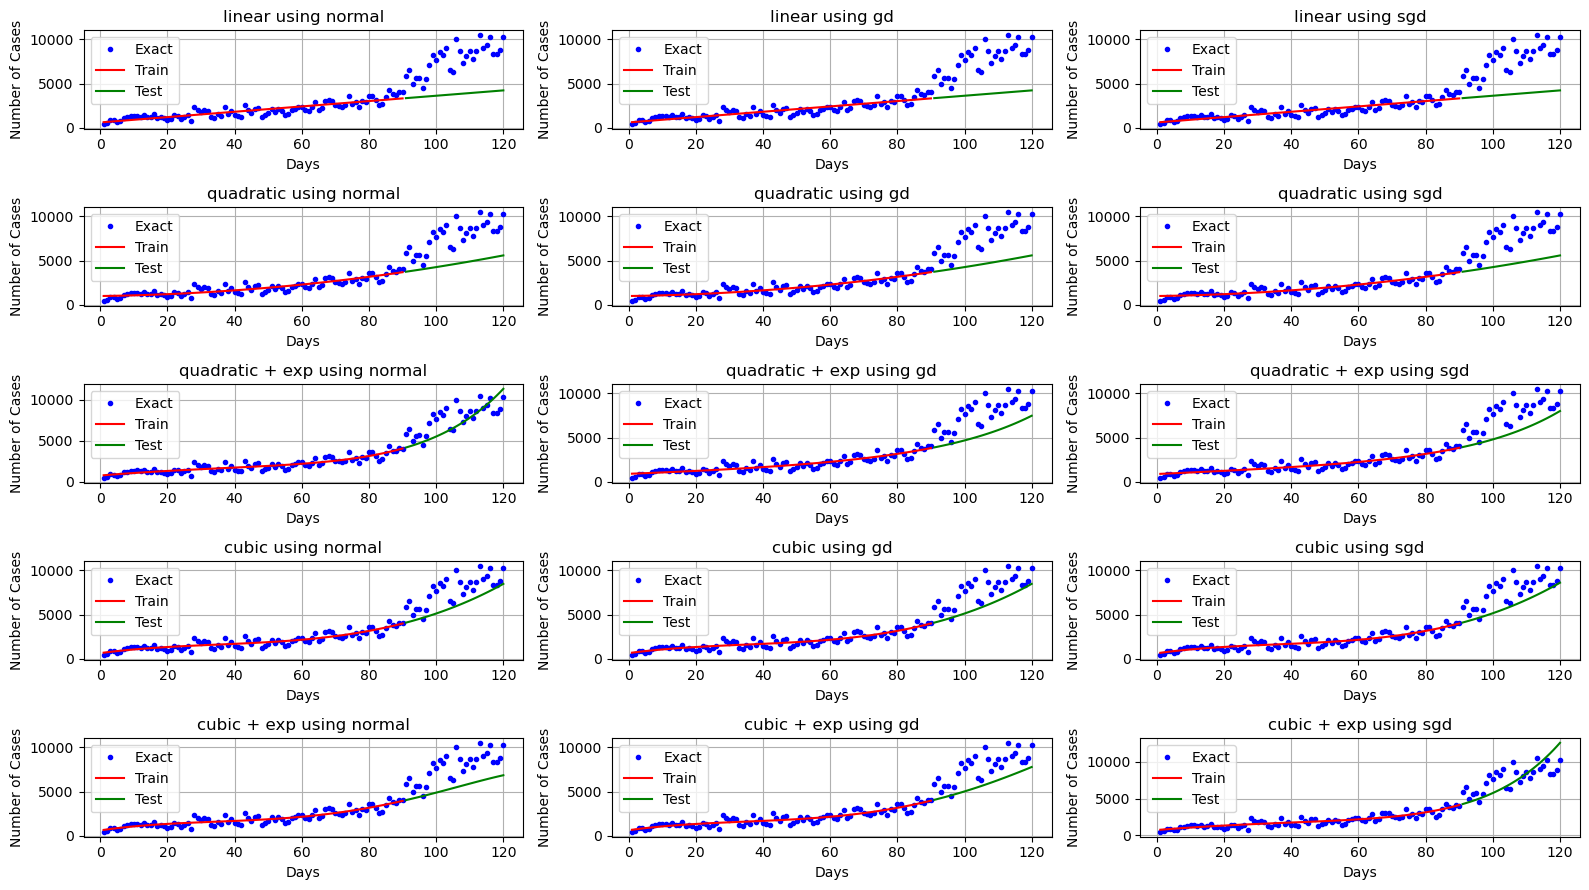

In [35]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import itertools as it
import pandas as pd

#Import Data
data = np.loadtxt("CaCovidInfMarch24toMidJuly.txt")
t = np.arange(1,len(data)+1,1)

X_train, X_test, y_train, y_test = train_test_split(t, data, train_size=90, shuffle=False)

#Define the list of objective functions
def f_lin(x): return np.array([x**0, x])
def f_qua(x): return np.array([x**0, x, x**2])
def f_qua_exp(x): return np.array([x**0, x, x**2, np.exp(x)])
def f_cub(x): return np.array([x**0, x, x**2, x**3])
def f_cub_exp(x): return np.array([x**0, x, x**2, x**3, np.exp(x)])

obj_funcs = [
    {
        "name": "linear",
        "obj_fun": f_lin
    },
    {
        "name": "quadratic",
        "obj_fun": f_qua
    },
    {
        "name": "quadratic + exp",
        "obj_fun": f_qua_exp
    },
    {
        "name": "cubic",
        "obj_fun": f_cub
    },
    {
        "name": "cubic + exp",
        "obj_fun": f_cub_exp
    }
]


#Set up the method types and their paramters for regression
algos = [
    {
        "type": "normal",
        "gd_params": None  
    },
    {
        "type": "gd",
        "gd_params": {"lr": 0.001, "num_epochs": 1000}
    },
    {
        "type": "sgd",
        "gd_params": {"lr": 0.001, "num_epochs": 1000, "batch_size": 10}
    }  
]

#Set up figure and DataFrame for saving the results
fig, axs = plt.subplots(nrows=len(obj_funcs),
    ncols=len(algos),
    figsize=(16,9)
    )

column_names = [
    "obj_fun_name",
    "algo_type",
    "train_mse",
    "test_mse"
]
df_results = pd.DataFrame(columns=column_names)

#Run the simluations
for (obj_func, algo), ax in zip(it.product(obj_funcs, algos), axs.flat):
    regressor = CustomRegressors(obj_func["obj_fun"],
        type=algo["type"],
        gd_params=algo["gd_params"])
    
    regressor.fit(X_train, y_train)
    y_pred = regressor.pred(X_train)
    y_test_pred = regressor.pred(X_test)
    mse_train = mean_squared_error(y_train, y_pred, squared=False)
    mse_pred = mean_squared_error(y_test, y_test_pred, squared=False)

    temp_df = pd.DataFrame(
        [
            [
                obj_func["name"],
                algo["type"],
                mse_train,
                mse_pred
            ]
        ],
        columns=column_names
    )

    df_results = pd.concat([df_results, temp_df], ignore_index=True)
    ax.plot(X_train, y_train, "b.", label="Exact")
    ax.plot(X_train, y_pred, "r-", label="Train")
    ax.plot(X_test, y_test, "b.")
    ax.plot(X_test, y_test_pred, "g-", label="Test")

    ax.set_xlabel("Days")
    ax.set_ylabel("Number of Cases")
    ax.set_title(f'{obj_func["name"]} using {algo["type"]}')
    ax.legend(loc="upper left")
    ax.grid()

fig.tight_layout()
fig.show()
display(df_results)


From the figure above we can see that the higher degree polynomial perform better than lower degree ones. We will use test mean square error to pick the best model. Among the polynomial models, we have the cubic have the lowest error, in particular the cubic using stochastic gradient descent perform the best among all models. 

All of the polynomial models predictions are lower than the actual data. This makes sense as we would expect some type of exponential growth in the number of cases. As we can see that the exponential term is a good corrector in term of prediction.

Since, there are some randomness in stochastic gradient descent, we will use the normal and gradient solver to determine the best model if we do not have the randomness. From this perspective, cubic polynomial is best among the polynomial models. However, supprsingly, we have that quadratic + exp model is the best, in particular the normal equation solver performs the best. 